# Cross Validation

One of the primary challenges in time series forecasting is the inherent uncertainty and variability over time, making it crucial to validate the accuracy and reliability of the models employed. Cross-validation, a robust model validation technique, is particularly adapted for this task, as it provides insights into the expected performance of a model on unseen data, ensuring the forecasts are reliable and resilient before being deployed in real-world scenarios.

`TimeGPT`, understanding the intricate needs of time series forecasting, incorporates the `cross_validation` method, designed to streamline the validation process for time series models. This functionality enables practitioners to rigorously test their forecasting models against historical data, assessing their effectiveness while tuning them for optimal performance. This tutorial will guide you through the nuanced process of conducting cross-validation within the TimeGPT class, ensuring your time series forecasting models are not just well-constructed, but also validated for trustworthiness and precision.

In [ ]:
#| hide
from nixtlats.utils import colab_badge

In [ ]:
#| echo: false
colab_badge('docs/tutorials/9_cross_validation')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/9_cross_validation.ipynb)

In [ ]:
#| hide
import numpy as np
from dotenv import load_dotenv

In [ ]:
#| hide
load_dotenv()

True

In [ ]:
import pandas as pd
from nixtlats import TimeGPT

In [ ]:
timegpt = TimeGPT(
    # defaults to os.environ.get("TIMEGPT_TOKEN")
    token = 'my_token_provided_by_nixtla'
)

In [ ]:
#| hide
timegpt = TimeGPT()

The `cross_validation` method within the `TimeGPT` class is an advanced functionality crafted to perform systematic validation on time series forecasting models. This method necessitates a dataframe comprising time-ordered data and employs a rolling-window scheme to meticulously evaluate the model's performance across different time periods, thereby ensuring the model's reliability and stability over time. 

Key parameters include `freq`, which denotes the data's frequency and is automatically inferred if not specified. The `id_col`, `time_col`, and `target_col` parameters designate the respective columns for each series' identifier, time step, and target values. The method offers customization through parameters like `n_windows`, indicating the number of separate time windows on which the model is assessed, and `step_size`, determining the gap between these windows. If `step_size` is unspecified, it defaults to the forecast horizon `h`. 

The process also allows for model refinement via `fewshot_steps`, specifying the number of iterations for model fine-tuning on new data. Data pre-processing is manageable through `clean_ex_first`, deciding whether to cleanse the exogenous signal prior to forecasting. Additionally, the method supports enhanced feature engineering from time data through the `date_features` parameter, which can automatically generate crucial date-related features or accept custom functions for bespoke feature creation. The `date_features_to_one_hot` parameter further enables the transformation of categorical date features into a format suitable for machine learning models.

In execution, `cross_validation` assesses the model's forecasting accuracy in each window, providing a robust view of the model's performance variability over time and potential overfitting. This detailed evaluation ensures the forecasts generated are not only accurate but also consistent across diverse temporal contexts.

In [ ]:
pm_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/peyton_manning.csv')
timegpt_cv_df = timegpt.cross_validation(
    pm_df, 
    h=7, 
    n_windows=5, 
    time_col='timestamp', 
    target_col='value', 
    freq='D',
)
timegpt_cv_df.head()

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...


,timestamp,cutoff,value,TimeGPT
0,2015-12-17,2015-12-16,7.591862,7.939553
1,2015-12-18,2015-12-16,7.528869,7.887512
2,2015-12-19,2015-12-16,7.171657,7.766617
3,2015-12-20,2015-12-16,7.891331,7.931502
4,2015-12-21,2015-12-16,8.360071,8.312632


In [ ]:
from IPython.display import display

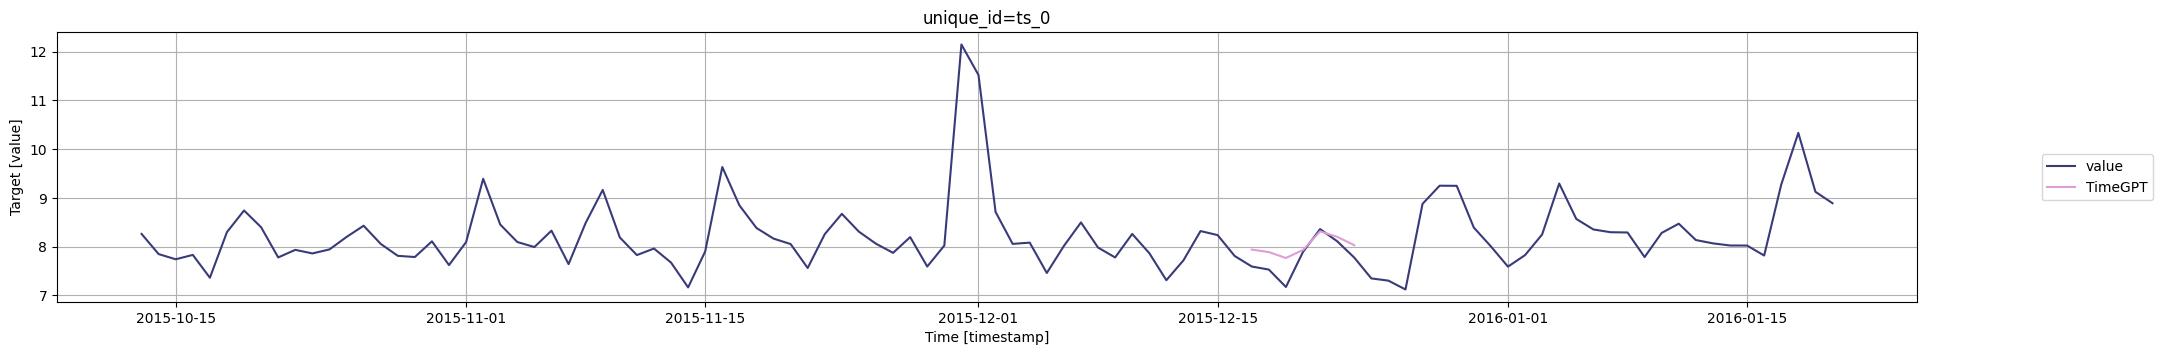

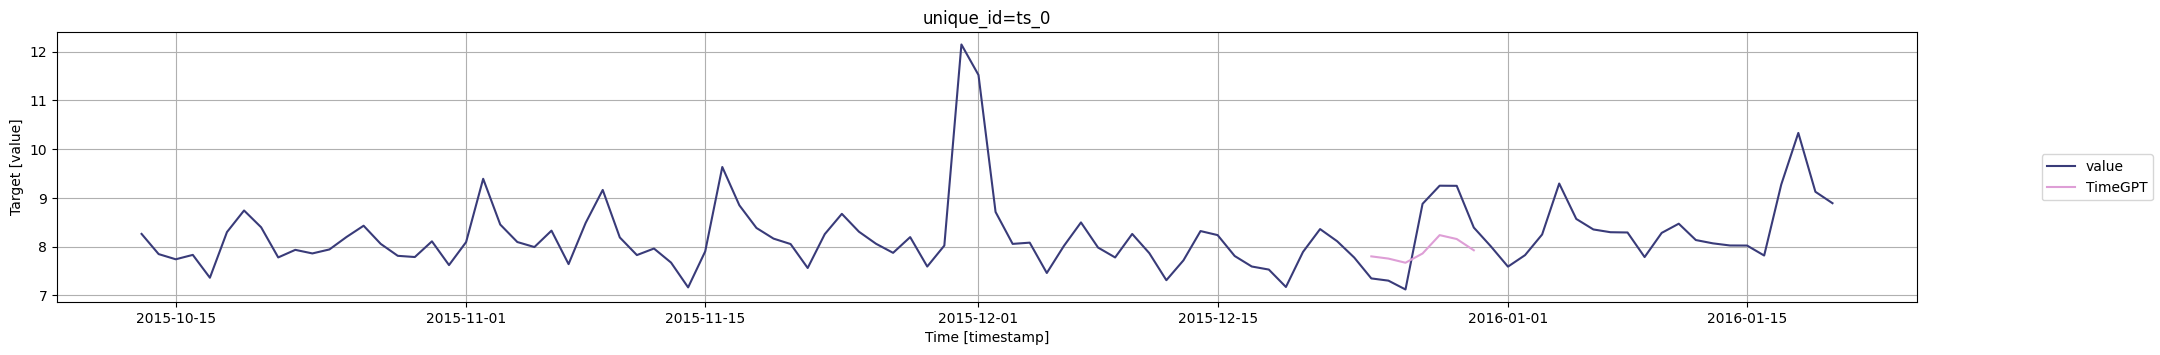

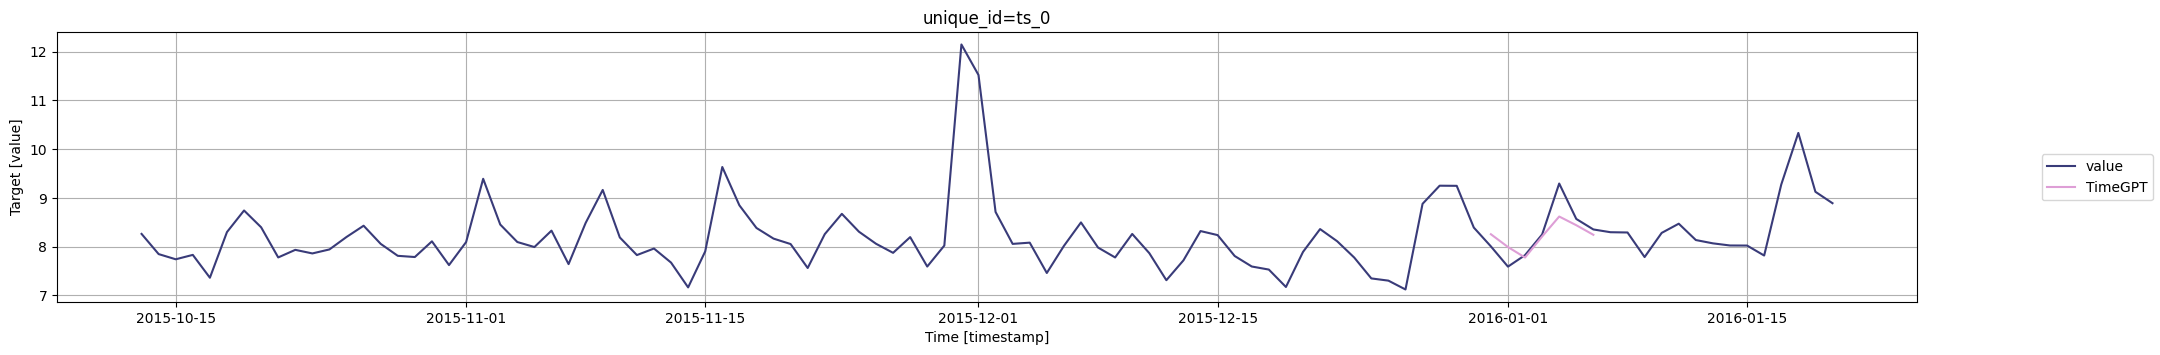

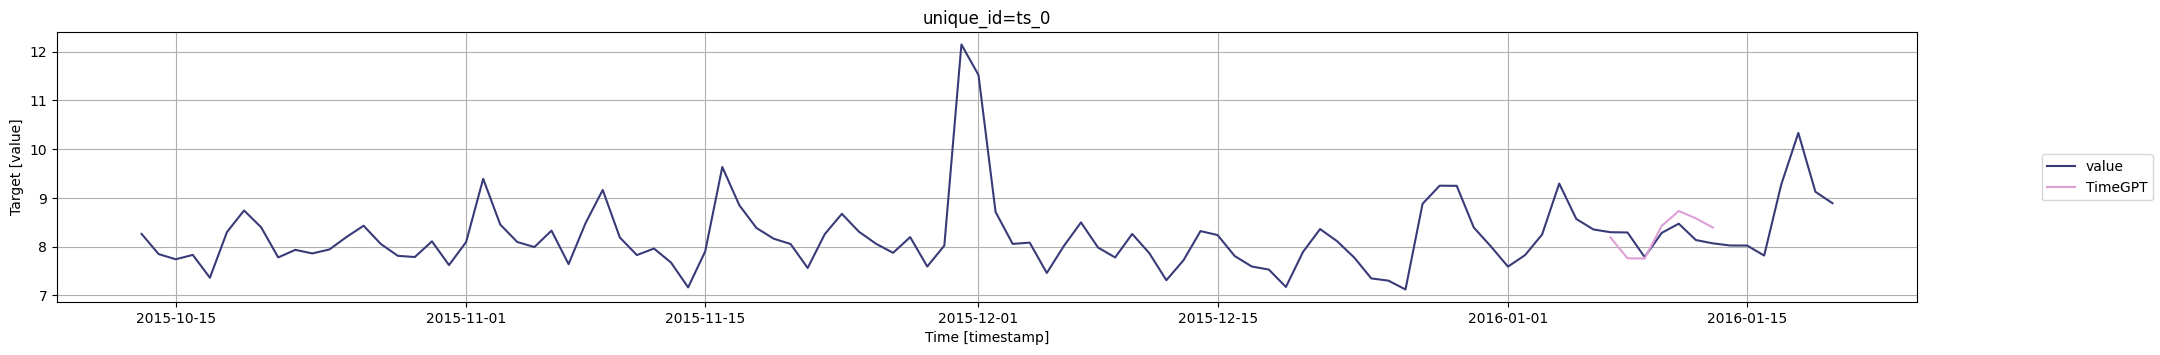

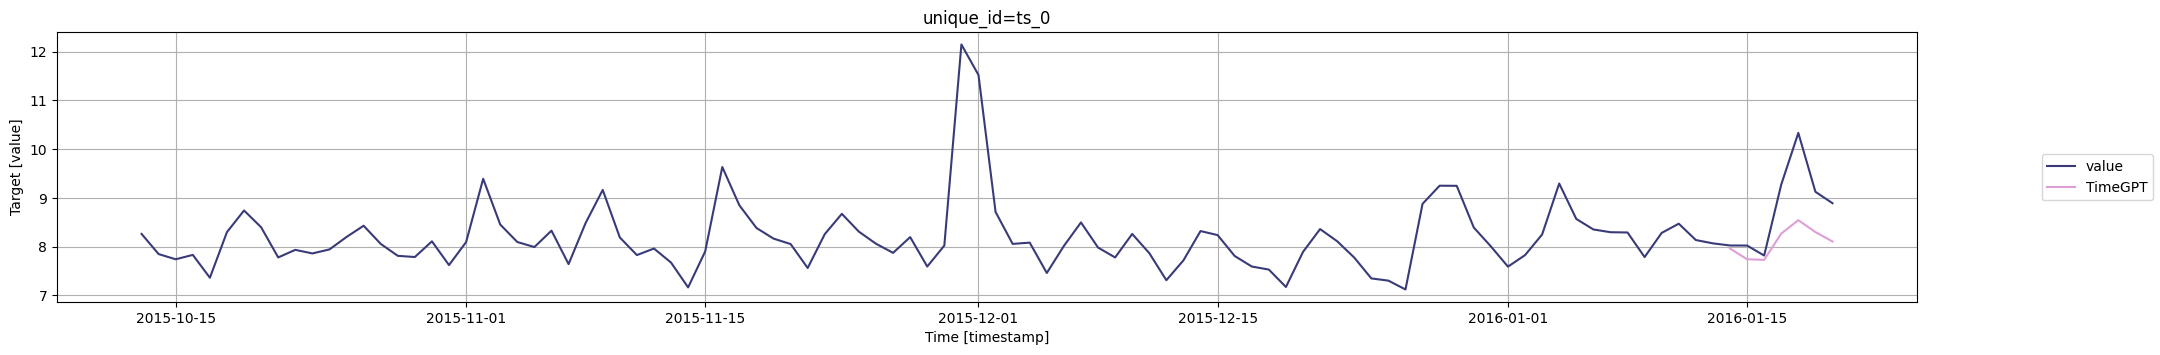

In [ ]:
cutoffs = timegpt_cv_df['cutoff'].unique()
for cutoff in cutoffs:
    fig = timegpt.plot(
        pm_df.tail(100), 
        timegpt_cv_df.query('cutoff == @cutoff').drop(columns=['cutoff', 'value']),
        time_col='timestamp', 
        target_col='value'
    )
    display(fig)

To asses the performance of `TimeGPT` with distributional forecasts, you can produce prediction intervals using the `level` argument.

In [ ]:
timegpt_cv_df = timegpt.cross_validation(
    pm_df, 
    h=7, 
    n_windows=5, 
    time_col='timestamp', 
    target_col='value', 
    freq='D',
    level=[80, 90],
)
timegpt_cv_df.head()

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Restricting input...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Restricting input...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Restricting input...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Restricting input...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inpu

,timestamp,cutoff,value,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,2015-12-17,2015-12-16,7.591862,7.939553,7.564151,7.675945,8.203161,8.314956
1,2015-12-18,2015-12-16,7.528869,7.887512,7.567342,7.598298,8.176726,8.207681
2,2015-12-19,2015-12-16,7.171657,7.766617,7.146560,7.266829,8.266404,8.386674
3,2015-12-20,2015-12-16,7.891331,7.931502,7.493021,7.657075,8.205929,8.369982
4,2015-12-21,2015-12-16,8.360071,8.312632,7.017335,7.446677,9.178586,9.607928


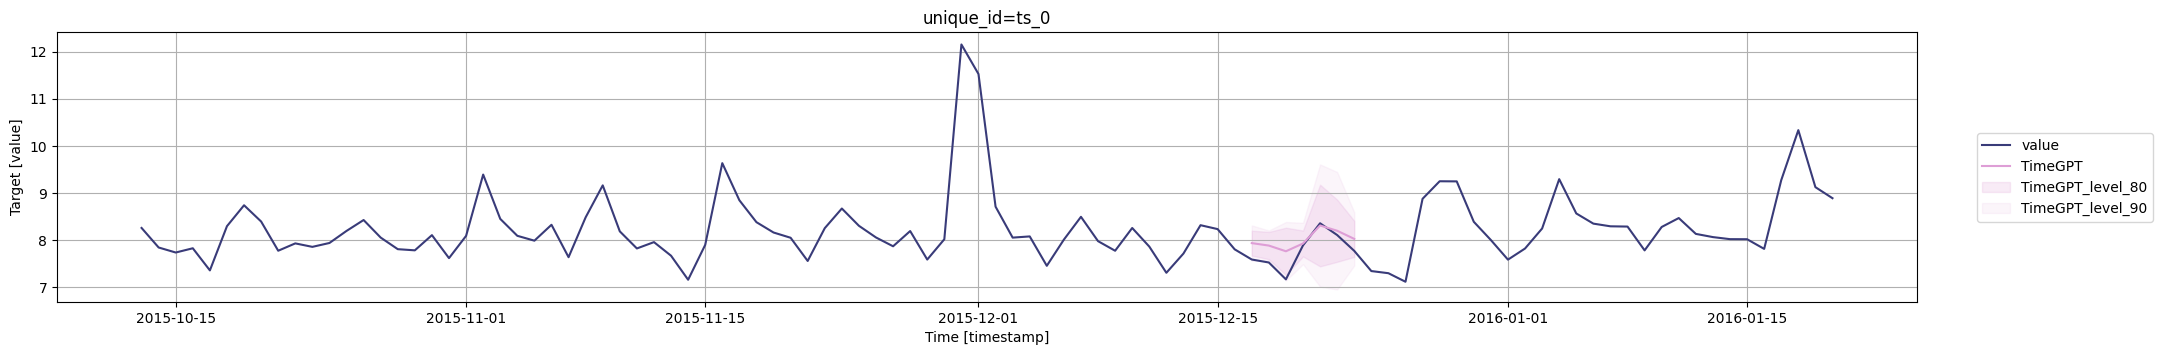

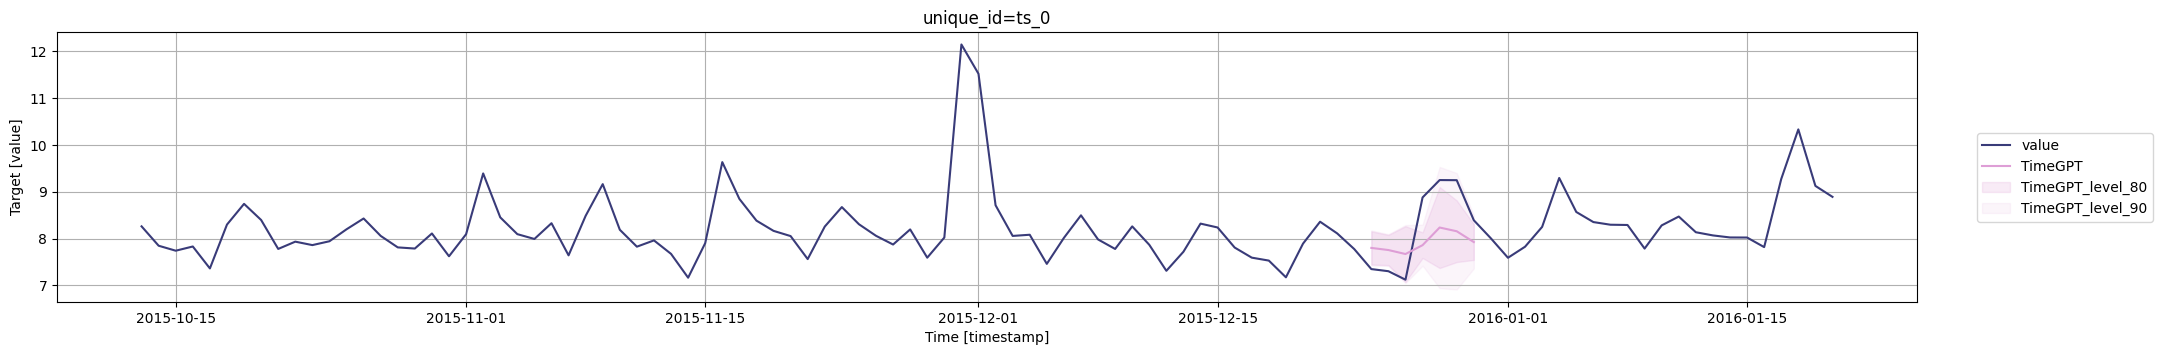

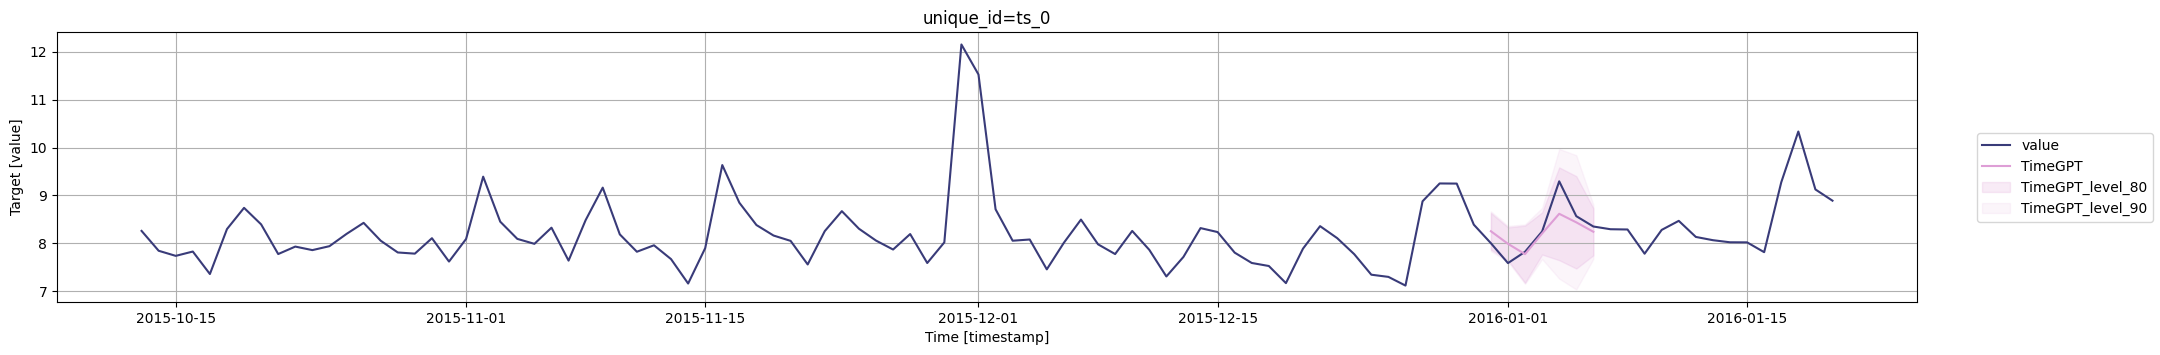

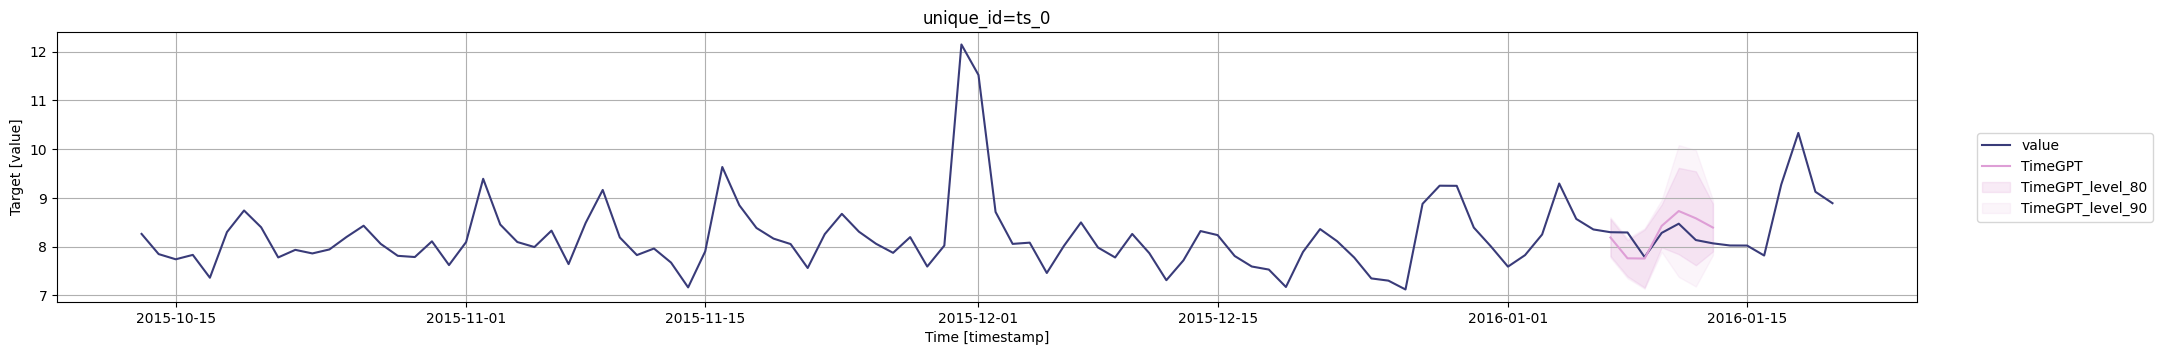

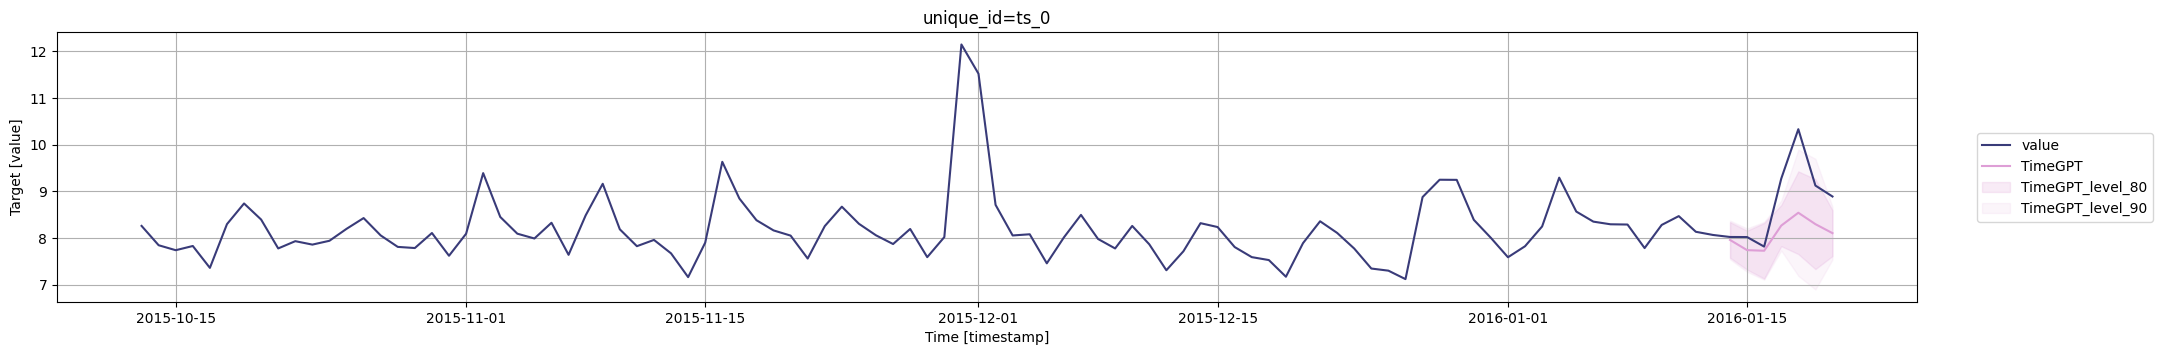

In [ ]:
cutoffs = timegpt_cv_df['cutoff'].unique()
for cutoff in cutoffs:
    fig = timegpt.plot(
        pm_df.tail(100), 
        timegpt_cv_df.query('cutoff == @cutoff').drop(columns=['cutoff', 'value']),
        time_col='timestamp', 
        target_col='value',
        level=[80, 90],
        models=['TimeGPT']
    )
    display(fig)

You can also include `date_features` to see their impact in forecasting accuracy:

In [ ]:
timegpt_cv_df = timegpt.cross_validation(
    pm_df, 
    h=7, 
    n_windows=5, 
    time_col='timestamp', 
    target_col='value', 
    freq='D',
    level=[80, 90],
    date_features=['month'],
)
timegpt_cv_df.head()

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Using the following exogenous variables: month_1, month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10, month_11, month_12
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Using the following exogenous variables: month_1, month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, month_10, month_11, month_12
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Using the following exogenous variables: month_1, month_2, month_3, month_4, month_5, month_6, month_7, month_8, month_9, 

,timestamp,cutoff,value,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,2015-12-17,2015-12-16,7.591862,7.945311,7.542366,7.647852,8.242769,8.348255
1,2015-12-18,2015-12-16,7.528869,7.892559,7.271274,7.481059,8.304058,8.513843
2,2015-12-19,2015-12-16,7.171657,7.771581,7.113544,7.281711,8.261451,8.429619
3,2015-12-20,2015-12-16,7.891331,7.939502,6.988198,7.345371,8.533633,8.890807
4,2015-12-21,2015-12-16,8.360071,8.320170,7.140163,7.658314,8.982027,9.500178


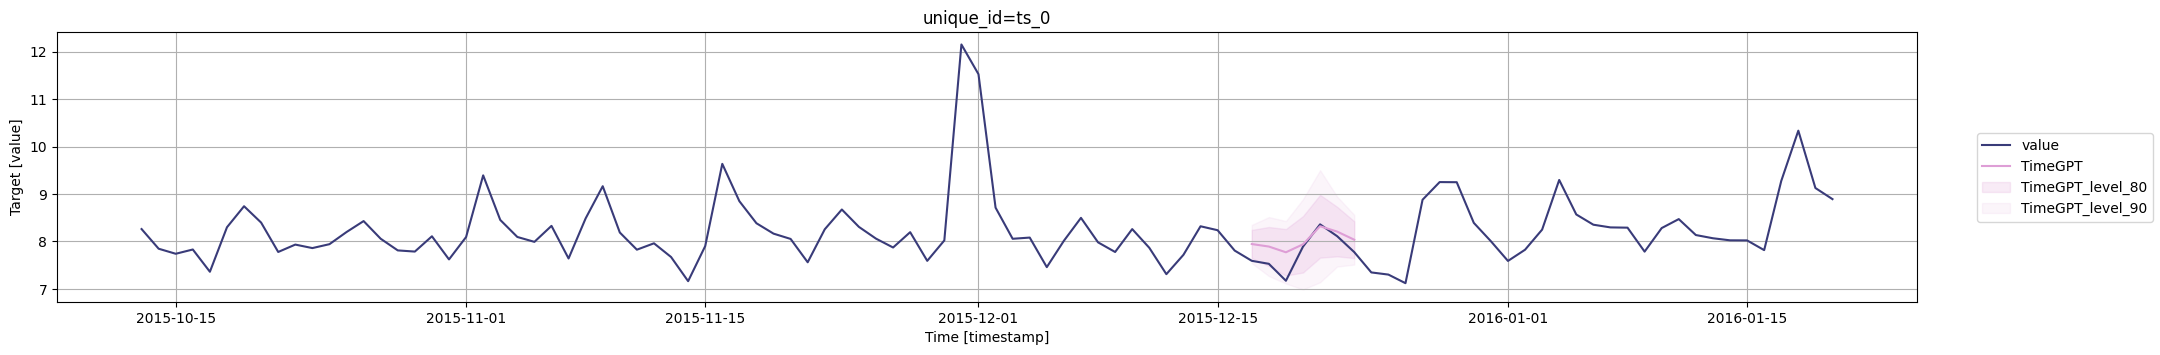

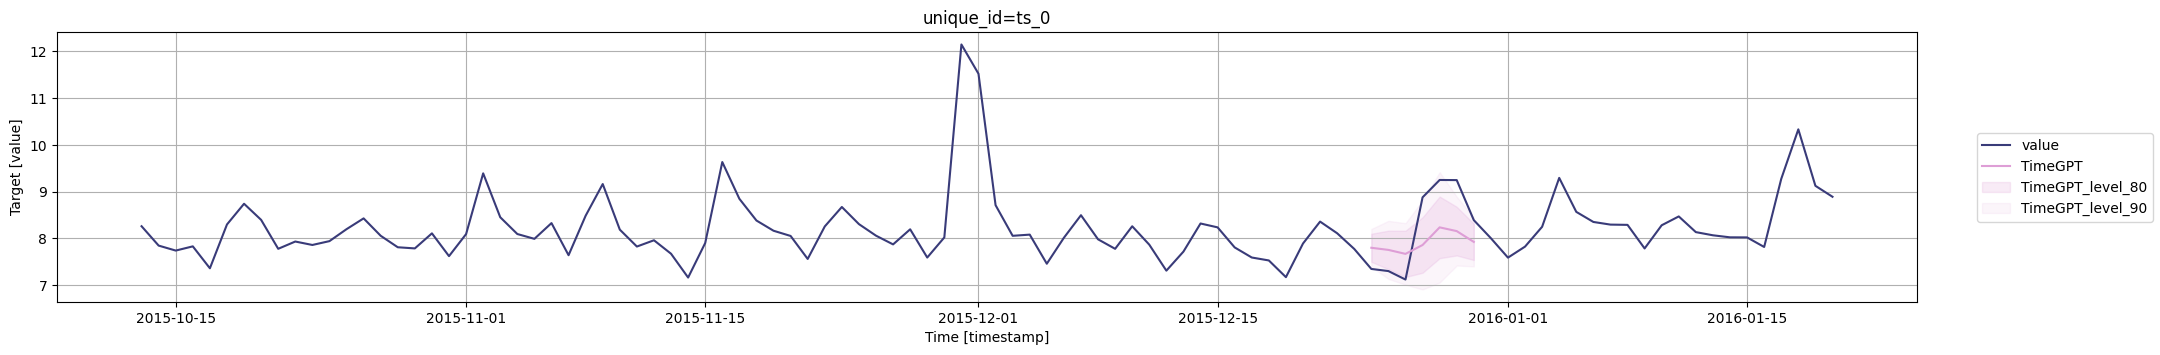

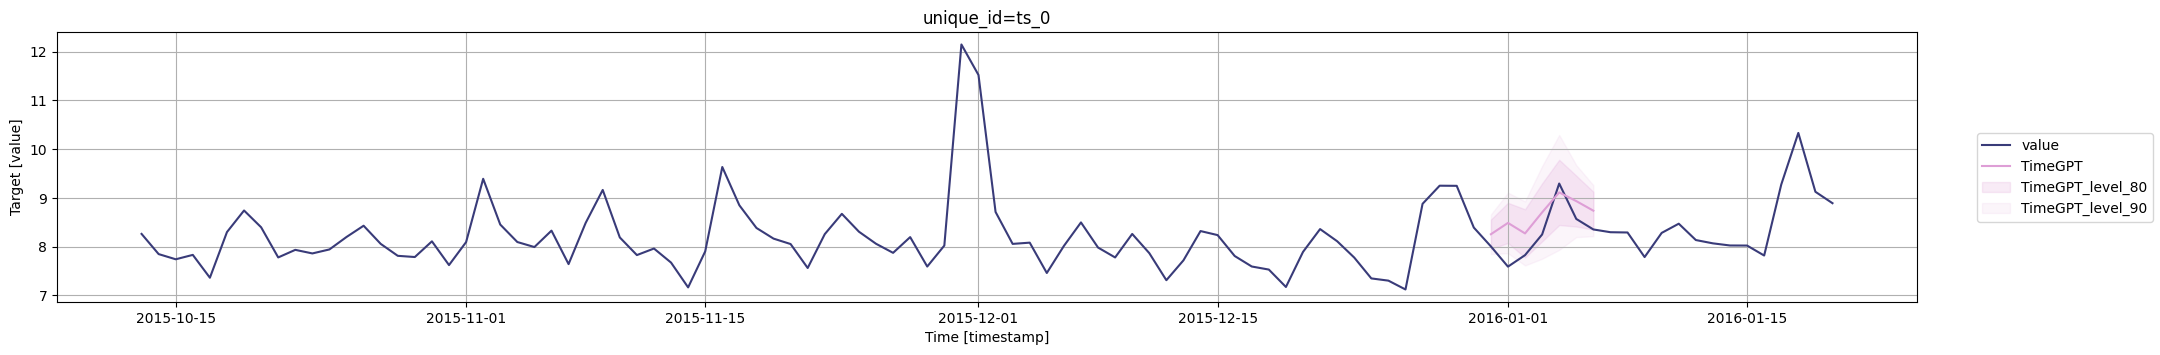

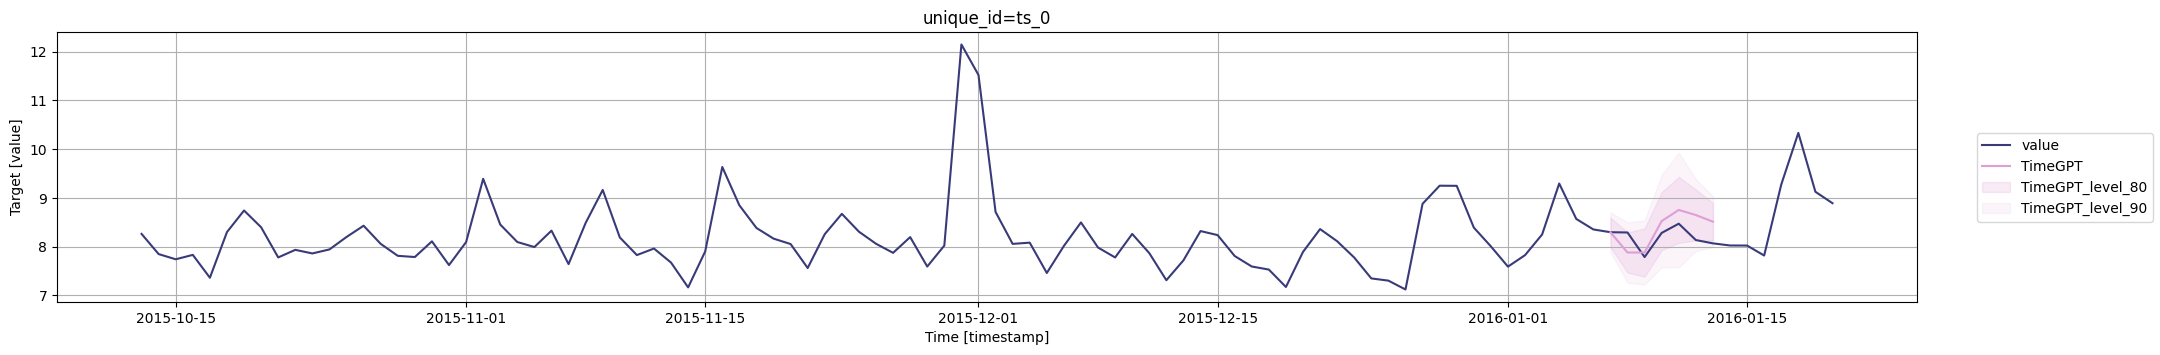

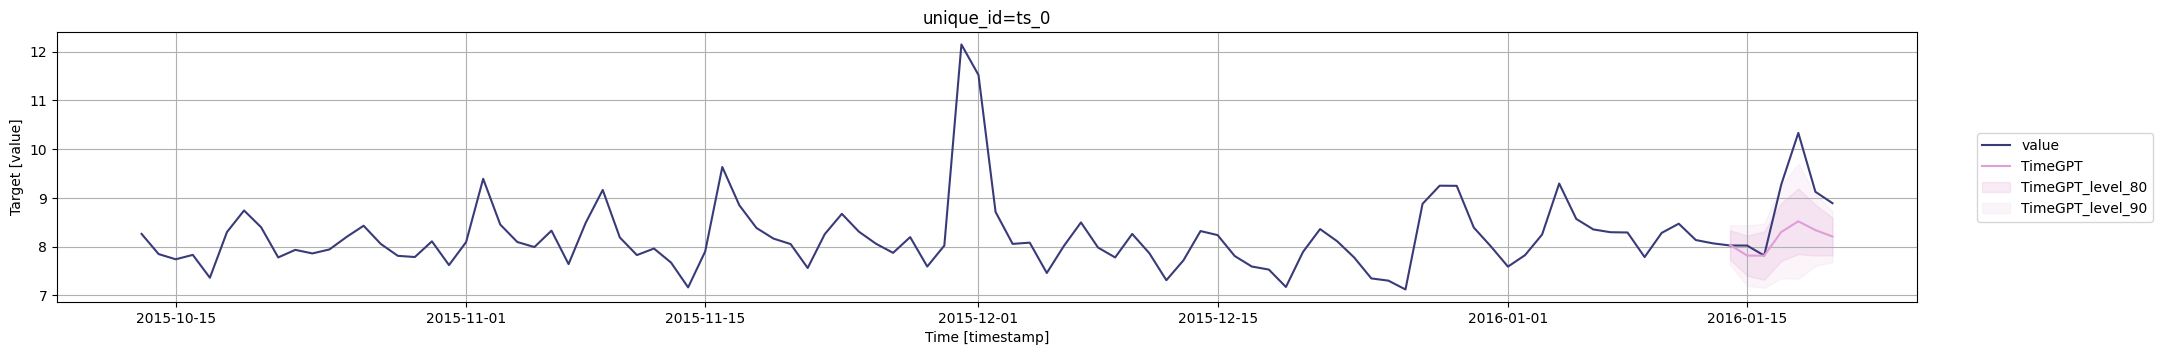

In [ ]:
cutoffs = timegpt_cv_df['cutoff'].unique()
for cutoff in cutoffs:
    fig = timegpt.plot(
        pm_df.tail(100), 
        timegpt_cv_df.query('cutoff == @cutoff').drop(columns=['cutoff', 'value']),
        time_col='timestamp', 
        target_col='value',
        level=[80, 90],
        models=['TimeGPT']
    )
    display(fig)

#### Exogenous variables

Additionally you can pass exogenous variables to better inform `TimeGPT` about the data. You just simply have to add the exogenous regressors after the target column.

In [ ]:
Y_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity.csv')
X_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/exogenous-vars-electricity.csv')
df = Y_df.merge(X_df)

Now let's cross validate `TimeGPT` considering this information

In [ ]:
#| hide
timegpt = TimeGPT(max_retries=2, retry_interval=5)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Inferred freq: H
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: H
INFO:nixtlats.timegpt:Using the following exogenous variables: Exogenous1, Exogenous2, day_0, day_1, day_2, day_3, day_4, day_5, day_6
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: H
INFO:nixtlats.timegpt:Using the following exogenous variables: Exogenous1, Exogenous2, day_0, day_1, day_2, day_3, day_4, day_5, day_6
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...


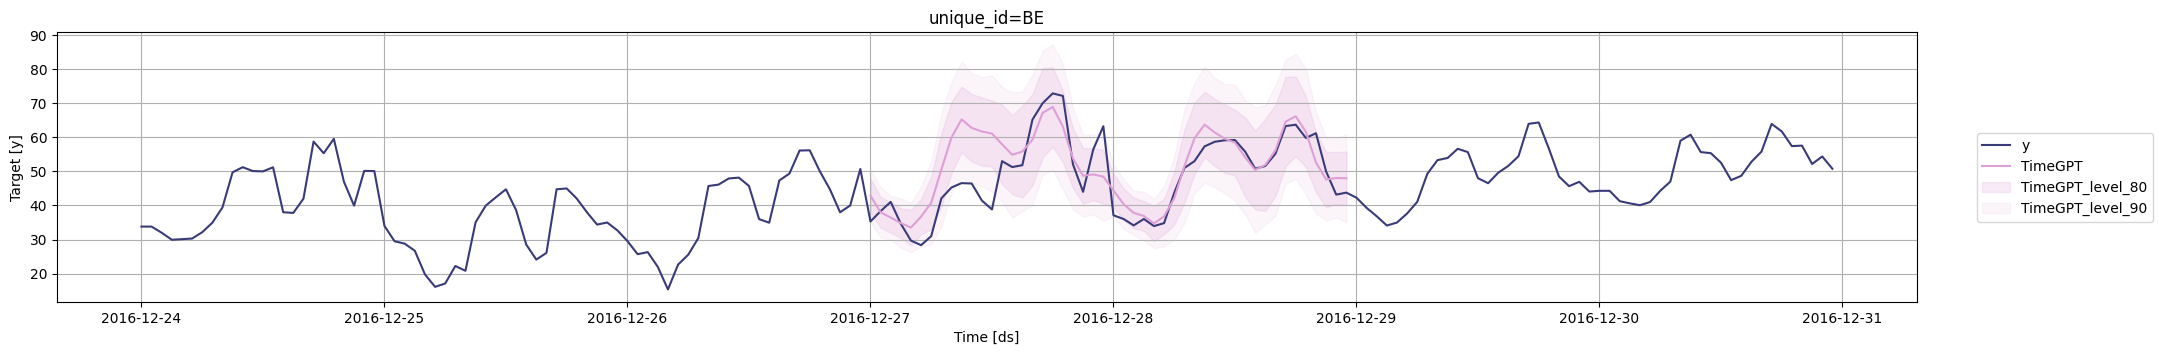

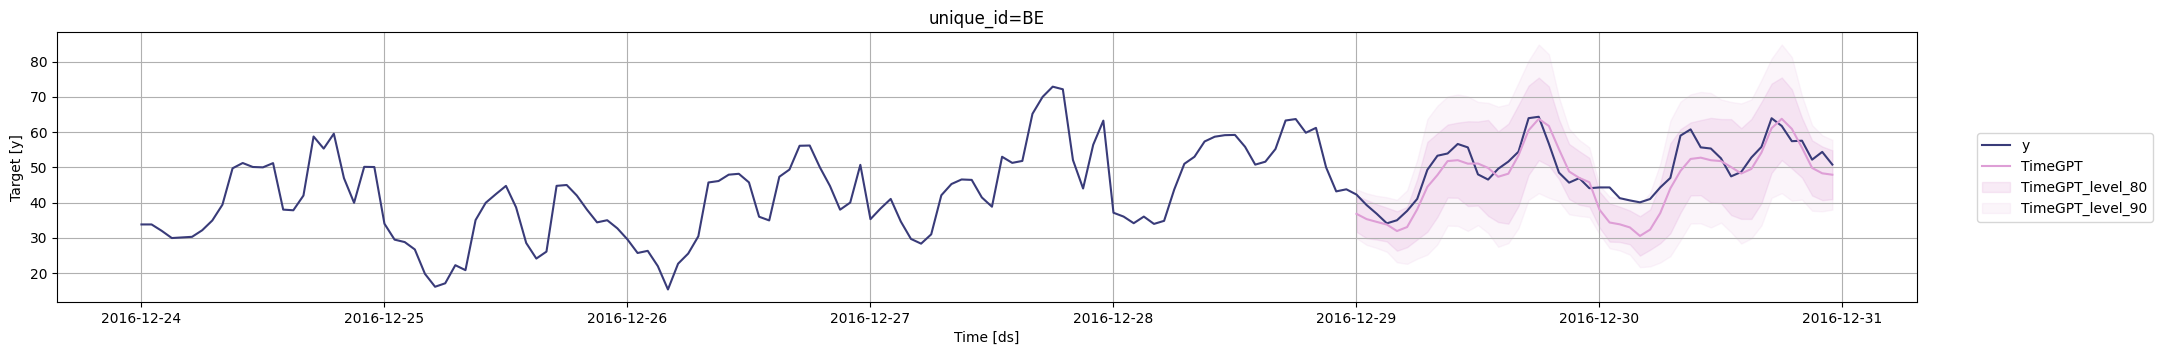

In [ ]:
timegpt_cv_df_x = timegpt.cross_validation(
    df.groupby('unique_id').tail(100 * 48), 
    h=48, 
    n_windows=2,
    level=[80, 90]
)
cutoffs = timegpt_cv_df_x.query('unique_id == "BE"')['cutoff'].unique()
for cutoff in cutoffs:
    fig = timegpt.plot(
        df.query('unique_id == "BE"').tail(24 * 7), 
        timegpt_cv_df_x.query('cutoff == @cutoff & unique_id == "BE"').drop(columns=['cutoff', 'y']),
        models=['TimeGPT'],
        level=[80, 90],
    )
    display(fig)

#### Compare different models

Also, you can generate cross validation for different instances of `TimeGPT` using the `model` argument.

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Inferred freq: H
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: H
INFO:nixtlats.timegpt:Using the following exogenous variables: Exogenous1, Exogenous2, day_0, day_1, day_2, day_3, day_4, day_5, day_6
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: H
INFO:nixtlats.timegpt:Using the following exogenous variables: Exogenous1, Exogenous2, day_0, day_1, day_2, day_3, day_4, day_5, day_6
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Validating inputs...


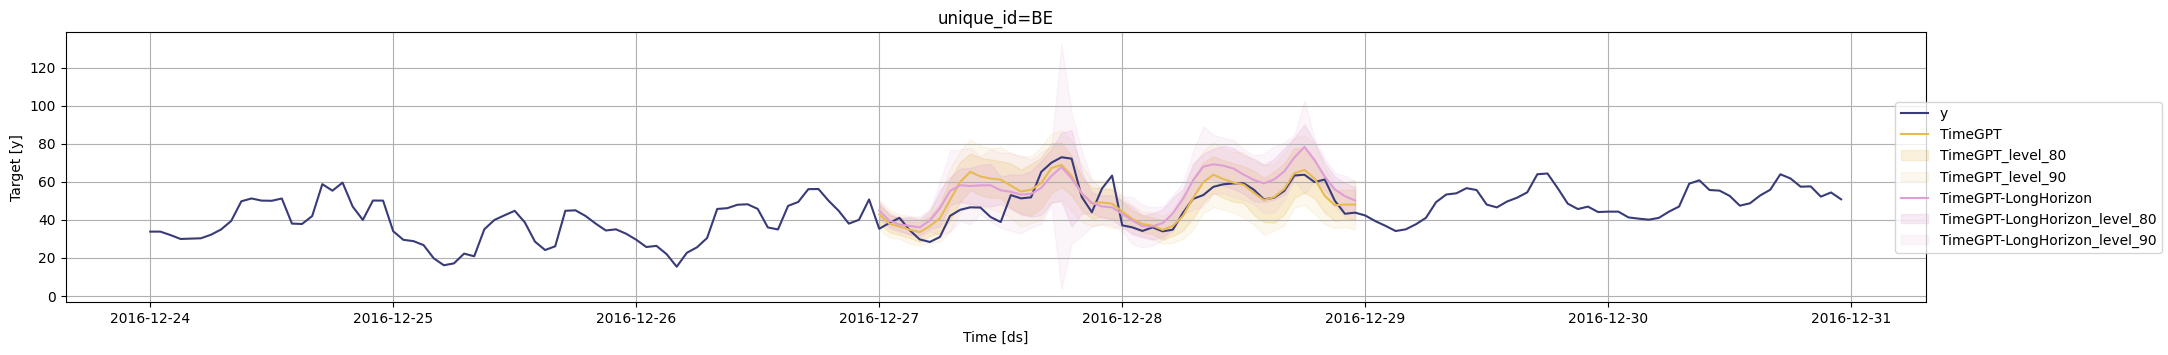

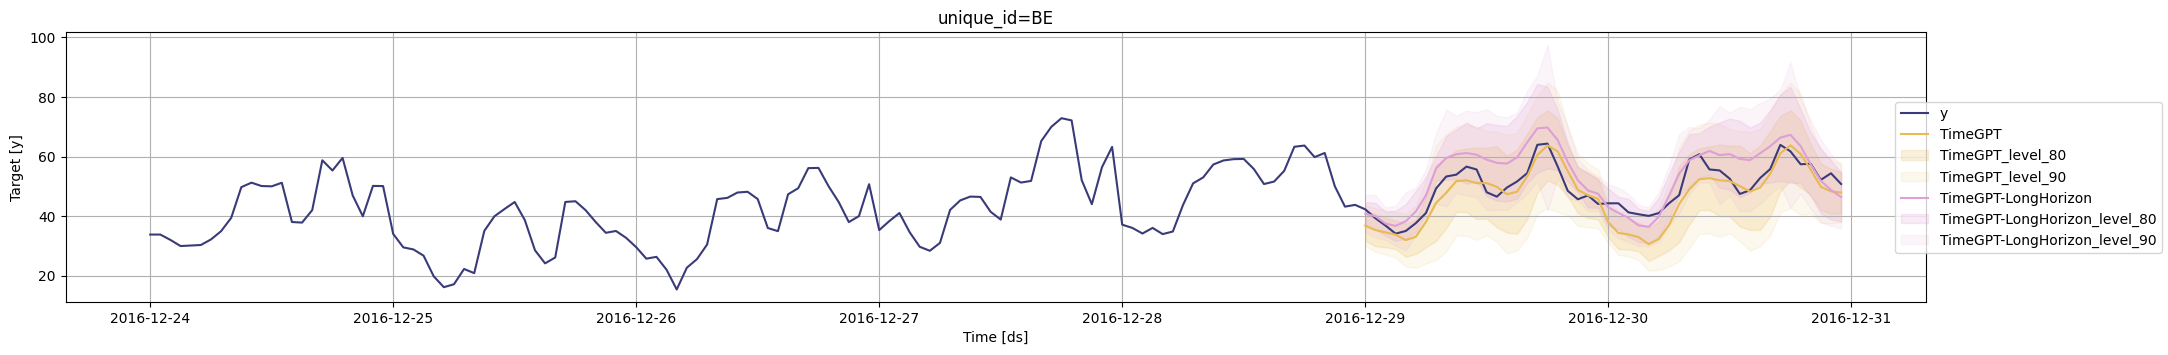

In [ ]:
timegpt_cv_df_x_long_horizon = timegpt.cross_validation(
    df.groupby('unique_id').tail(100 * 48), 
    h=48, 
    n_windows=2,
    level=[80, 90],
    model='long-horizon',
)
timegpt_cv_df_x_long_horizon.columns = timegpt_cv_df_x_long_horizon.columns.str.replace('TimeGPT', 'TimeGPT-LongHorizon')
timegpt_cv_df_x_models = timegpt_cv_df_x_long_horizon.merge(timegpt_cv_df_x)
cutoffs = timegpt_cv_df_x_models.query('unique_id == "BE"')['cutoff'].unique()
for cutoff in cutoffs:
    fig = timegpt.plot(
        df.query('unique_id == "BE"').tail(24 * 7), 
        timegpt_cv_df_x_models.query('cutoff == @cutoff & unique_id == "BE"').drop(columns=['cutoff', 'y']),
        models=['TimeGPT', 'TimeGPT-LongHorizon'],
        level=[80, 90],
    )
    display(fig)